# Feature Extraction

## Data Process

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/cu-master-data/feature-engineering/03_Assignment
# %cd /content/sample_data

Mounted at /content/drive/
/content/drive/MyDrive/cu-master-data/feature-engineering/03_Assignment


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from statsmodels.stats.proportion import proportions_ztest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

## Functions

In [6]:
def load():
    data = pd.read_csv("diabetes.csv")
    return data

In [7]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [8]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [9]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"] #değişken tipi object ise
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [10]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [11]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [12]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [13]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [14]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

In [15]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [16]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [17]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [18]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [19]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [20]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

In [21]:
def plot_importance(model, features, num, save=False):
    """Plots feature importance for tree-based models."""
    if hasattr(model, 'feature_importances_'):  # Check if model has feature_importances_
        feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                          ascending=False)[0:num])
        plt.title('Features')
        plt.tight_layout()
        plt.show()
        if save:
            plt.savefig('importances.png')
    else:
        print("Feature importance is not available for this model type.")  # Print a message if not available

In [22]:
def zero_to_nan(df, col):
    # Handle case sensitivity by converting col to uppercase
    col = col.upper()
    df[col] = df[col].replace(0, np.nan)
    return df

In [23]:
def check_zero(df, col):
    # Convert col to uppercase to match the column names in the DataFrame
    col = col.upper()
    if (df[col] == 0).sum() > 0:
        return True
    else:
        return False

## Data Preprocessing

In [24]:
df = load()
df.shape

(768, 9)

In [25]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [26]:
df.columns = [col.upper() for col in df.columns]
df.columns

Index(['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'OUTCOME'], dtype='object')

In [27]:
check_zero(df, "GLUCOSE")

True

In [28]:
check_zero(df, "Insulin")

True

In [30]:
# zero_to_nan(df,"GLUCOSE")

In [32]:
# zero_to_nan(df,"Insulin")

## Process

### 1. Feature Engineering

In [33]:
# age level
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'
# df.head()

In [34]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 10
cat_cols: 2
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [35]:
cat_cols

['NEW_AGE_CAT', 'OUTCOME']

In [36]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE']

### 2. Outliers (Aykırı Değerler)

In [37]:
for col in num_cols:
    print(col, check_outlier(df, col))

PREGNANCIES True
GLUCOSE False
BLOODPRESSURE True
SKINTHICKNESS True
INSULIN True
BMI True
DIABETESPEDIGREEFUNCTION True
AGE True


In [38]:
for col in num_cols:
    replace_with_thresholds(df, col)

<ipython-input-12-f92e16e0483f>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-6.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
<ipython-input-12-f92e16e0483f>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


In [39]:
for col in num_cols:
    print(col, check_outlier(df, col))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN False
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


### 3. Missing Values (Eksik Değerler)

In [40]:
missing_values_table(df)

         n_miss  ratio
INSULIN     374 48.700
GLUCOSE       5  0.650


In [41]:
# Fill missing values in 'Insulin' and 'Glucose' with their respective medians
df['INSULIN'] = df['INSULIN'].fillna(df['INSULIN'].median())
df['GLUCOSE'] = df['GLUCOSE'].fillna(df['GLUCOSE'].median())

In [42]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


### 4. Encoding

In [43]:
df = one_hot_encoder(df, cat_cols)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_AGE_CAT_senior,OUTCOME_1
0,6.000,148.000,72,35,125.000,33.600,0.627,50.000,False,True
1,1.000,85.000,66,29,125.000,26.600,0.351,31.000,False,False
2,8.000,183.000,64,0,125.000,23.300,0.672,32.000,False,True
3,1.000,89.000,66,23,94.000,28.100,0.167,21.000,False,False
4,0.000,137.000,40,35,168.000,43.100,1.200,33.000,False,True


In [44]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and (df[col].value_counts() / len(df) < 0.01).any(axis=None)]
useless_cols

[]

### 5. Standart Scaling

In [45]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df[num_cols].head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE
0,0.647,0.866,0.093,0.915,-0.168,0.209,0.589,1.446
1,-0.849,-1.205,-0.330,0.536,-0.168,-0.784,-0.378,-0.189
2,1.246,2.017,-0.471,-1.295,-0.168,-1.253,0.747,-0.103
3,-0.849,-1.074,-0.330,0.157,-0.642,-0.571,-1.023,-1.050
4,-1.148,0.504,-2.163,0.915,0.488,1.558,2.597,-0.017


In [46]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_AGE_CAT_senior,OUTCOME_1
0,0.647,0.866,0.093,0.915,-0.168,0.209,0.589,1.446,False,True
1,-0.849,-1.205,-0.330,0.536,-0.168,-0.784,-0.378,-0.189,False,False
2,1.246,2.017,-0.471,-1.295,-0.168,-1.253,0.747,-0.103,False,True
3,-0.849,-1.074,-0.330,0.157,-0.642,-0.571,-1.023,-1.050,False,False
4,-1.148,0.504,-2.163,0.915,0.488,1.558,2.597,-0.017,False,True


In [47]:
df.shape

(768, 10)

## Model 1

In [48]:
y = df["OUTCOME_1"]
X = df.drop(["OUTCOME_1", "SKINTHICKNESS"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7705627705627706

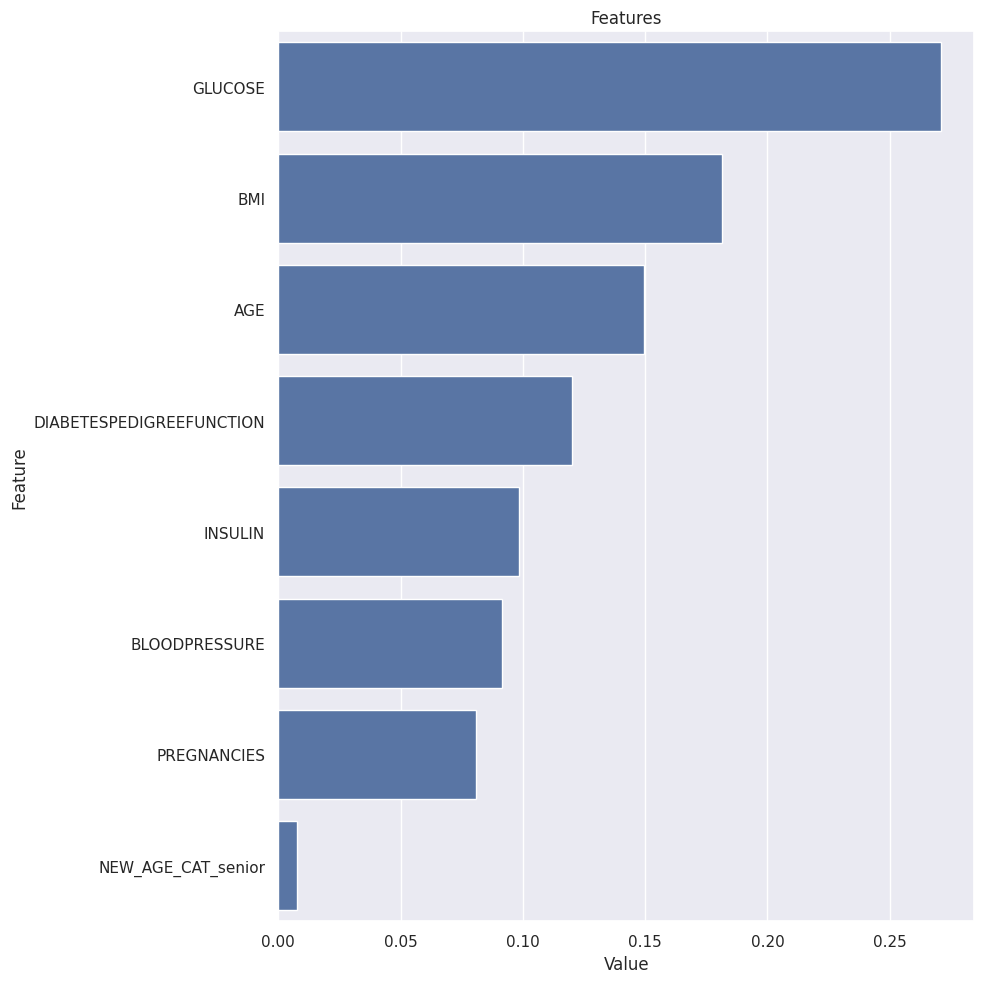

In [49]:
num=len(X)
plot_importance(rf_model, X_train,num)

In [50]:
dff=load()
y = dff["Outcome"]
X = dff.drop(["Outcome", "SkinThickness"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7575757575757576

## Model 2

In [51]:
dff=load()

In [52]:
# Support Vector Machine
y = df["OUTCOME_1"]
X = df.drop(["OUTCOME_1", "SKINTHICKNESS"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
svm_model = SVC(random_state=46).fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7402597402597403

In [53]:
num=len(X)
plot_importance(svm_model, X_train,num)

Feature importance is not available for this model type.


In [54]:
dff=load()
y = dff["Outcome"]
X = dff.drop(["Outcome", "SkinThickness"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
svm_model = SVC(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7575757575757576

## Model 3

In [55]:
# Decision Tree
y = df["OUTCOME_1"]
X = df.drop(["OUTCOME_1"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
dt_model = DecisionTreeClassifier(random_state=46).fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7316017316017316

In [56]:
dff=load()
y = dff["Outcome"]
X = dff.drop(["Outcome"], axis=1) # Remove SkinThickness from drop
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
dt_model = DecisionTreeClassifier(random_state=46).fit(X_train, y_train)
y_pred = dt_model.predict(X_test) # Predict using the Decision Tree model
accuracy_score(y_test, y_pred)

0.70995670995671